In [82]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,eye
from scipy.sparse.linalg import eigs,inv
%matplotlib inline

In [109]:
data = pd.read_csv('data/round_train.csv')

In [110]:
data = data[data.Tournament_Year.isin([2003,2004])]

In [111]:
data.shape

(38626, 12)

In [112]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [113]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [114]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [115]:
rounds = data.groupby(['Tournament_Year','Tournament_#','Round_Number'])

In [116]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)

In [117]:
print n_players,n_rounds

917 371


In [118]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [119]:
n_players*(n_rounds/4+1)

85281

In [157]:
BETA = .85
a = .8
bin_size = 30
n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
A = np.zeros((n_players*n_round_groups,n_players*n_round_groups))
G = np.zeros((n_players*n_round_groups,n_players*n_round_groups))
for round_ind,df in enumerate(rounds):
    df = df[1]
    round_group = round_ind/bin_size
#     if round_ind>=20:
#         continue
    arrs = np.zeros((n_players,n_players))
    arrs[np.ix_(pd.unique(df.Player_Index),pd.unique(df.Player_Index))] = np.outer(1/df.Round_Score.values.astype(float),df.Round_Score.values)
    np.fill_diagonal(arrs,0)
    arrs1 = (arrs!=0).astype(int)
    A[:,range(n_players*round_group,n_players*(round_group+1))] += \
    np.vstack([BETA**(abs(round_group-round_group2))*arrs for round_group2 in range(n_round_groups)])
    G[:,range(n_players*round_group,n_players*(round_group+1))] += \
    np.vstack([BETA**(abs(round_group-round_group2))*arrs1 for round_group2 in range(n_round_groups)])     
A,G = csr_matrix(A),csr_matrix(G)
S = eye(n_players*n_round_groups,format='csr') - alpha(A,a)*A
S_inv = inv(S)
w_a = S_inv.dot(A.sum(1))
S = eye(n_players*n_round_groups,format='csr') - alpha(G,a)*G
S_inv = inv(S)
w_g = S_inv.dot(G.sum(1))

In [128]:
print n_round_groups
print S.shape[0]**2

13
142110241


In [129]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.0855996085462


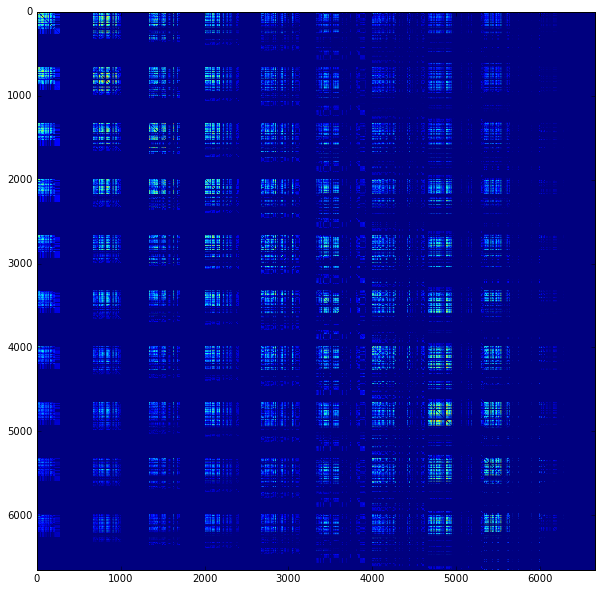

In [99]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A.toarray());

In [159]:
ranks = np.squeeze(np.asarray(w_a/w_g))

In [160]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [172]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[n_players*10:n_players*11]}).sort_values('rank',ascending=False)

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.044969
277,277,"Woods, Tiger",1.044928
12,12,"Els, Ernie",1.040997
793,793,"Levin, Spencer",1.037903
27,27,"Goosen, Retief",1.033161
162,162,"Mickelson, Phil",1.031385
532,532,"Ruiz, Marco",1.029932
341,341,"Harrington, Padraig",1.029468
841,841,"Felton, Kim",1.028063
331,331,"Scott, Adam",1.027938


In [161]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [162]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Singh, Vijay']]

In [163]:
# with_9 = [ranks[[j + i*n_players for i in range(n_round_groups)]] for j in inds_to_plot]
with_8 = [ranks[[j + i*n_players for i in range(n_round_groups)]] for j in inds_to_plot]

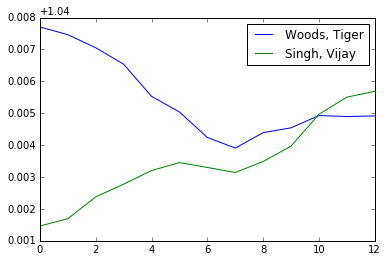

In [168]:
for j in inds_to_plot:
    plt.plot(ranks[[j + i*n_players for i in range(n_round_groups)]],label = inds_to_name[j]);
plt.legend();

# for i in [0,1]:
#     plt.plot(with_8[i])
#     plt.plot(with_9[i]);